In [1]:

from IPython.display import display

from pathlib import PurePath, Path


import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



In [2]:
def read_kibot_ticks(fp):
    # read tick data from http://www.kibot.com/support.aspx#data_format
    cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))
    df = (pd.read_csv(fp, header=None)
          .rename(columns=dict(zip(range(len(cols)),cols)))
          .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')))
          .assign(v=lambda df: df['size']) # volume
          .assign(dv=lambda df: df['price']*df['size']) # dollar volume
          .drop(['date','time'],axis=1)
          .set_index('dates')
          .drop_duplicates())
    return df
    
infp = PurePath('./data/IVE_tickbidask.txt')

df = read_kibot_ticks(infp)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2640389 entries, 2009-09-28 09:30:00 to 2023-12-08 16:00:00
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   bid     float64
 2   ask     float64
 3   size    int64  
 4   v       int64  
 5   dv      float64
dtypes: float64(4), int64(2)
memory usage: 141.0 MB


In [4]:
df.tail()

,price,bid,ask,size,v,dv
dates,,,,,,
2023-12-08 15:59:45,167.125,167.12,167.13,100,100,16712.50
2023-12-08 15:59:51,167.130,167.12,167.13,294,294,49136.22
2023-12-08 15:59:55,167.110,167.11,167.13,100,100,16711.00
2023-12-08 15:59:59,167.100,167.09,167.11,100,100,16710.00
2023-12-08 16:00:00,167.070,167.11,167.12,6796,6796,1135407.72


In [5]:
df.isna().sum()

price    0
bid      0
ask      0
size     0
v        0
dv       0
dtype: int64

<AxesSubplot:xlabel='price'>

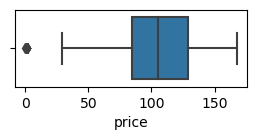

In [6]:
plt.figure(figsize=(3,1))
sns.boxplot(df,x='price')

<AxesSubplot:xlabel='dates'>

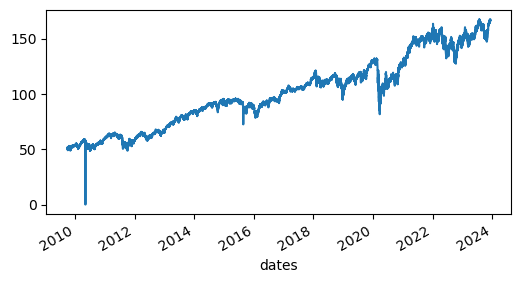

In [7]:
plt.figure(figsize=(6,3))
df['price'].plot()

- MAD outlier

In [8]:

y = df['price'].values.reshape(-1,1)
thresh = 3.
median = np.median(y)
diff = np.sum((y - median)**2, axis=-1)
diff = np.sqrt(diff)
med_abs_deviation = np.median(diff)
modified_z_score = 0.6745 * diff / med_abs_deviation
print((modified_z_score > thresh).sum())
mad_outlier = modified_z_score > thresh

11


- IQR outlier

In [9]:
weight = 1.5
q_25 = np.quantile(df['price'],0.25)
q_75 = np.quantile(df['price'],0.75)
iqr = q_75 - q_25
iqr_lower = q_25 - (iqr * weight)
iqr_upper = q_75 + (iqr * weight)
print(iqr_lower)
print(iqr_upper)


18.58999999999999
195.15


In [10]:
iqr_outlier = (df['price'] < iqr_lower) | (df['price'] > iqr_upper)
df['is_mad_ol'] = mad_outlier
df['is_iqr_ol'] = iqr_outlier

In [11]:
display(df[df['is_iqr_ol'] | df['is_iqr_ol']])

,price,bid,ask,size,v,dv,is_mad_ol,is_iqr_ol
dates,,,,,,,,
2010-05-06 14:49:07,0.11,0.10,44.03,500,500,55.0,True,True
2010-05-06 14:53:30,1.10,1.10,30.28,2600,2600,2860.0,True,True
2010-05-06 14:55:32,1.10,1.10,50.57,300,300,330.0,True,True
2010-05-06 14:55:32,1.10,1.10,50.57,100,100,110.0,True,True
2010-05-06 14:55:32,1.10,1.00,50.57,200,200,220.0,True,True
2010-05-06 14:55:32,1.10,1.00,50.57,700,700,770.0,True,True
2010-05-06 14:55:32,1.10,1.00,50.57,1200,1200,1320.0,True,True
2010-05-06 14:55:32,1.10,0.55,50.57,500,500,550.0,True,True
2010-05-06 14:55:32,1.10,0.55,50.57,100,100,110.0,True,True


<AxesSubplot:xlabel='dates'>

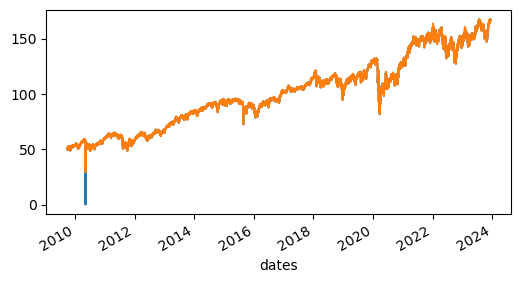

In [12]:
plt.figure(figsize=(6,3))
df['price'].plot()
df[~df['is_iqr_ol']]['price'].plot()

In [13]:
print(df.shape)
df = df[~df['is_mad_ol']].copy()
df = df.drop(columns=['is_mad_ol', 'is_iqr_ol'])
print(df.shape)
df.to_parquet('./data/IVE_tickbidask_ol_removed.parquet')

(2640389, 8)
(2640378, 6)


### tick bars

In [14]:
num_tick = 100
selected_tbar = [i-1 for i in range(num_tick,len(df),num_tick)]
df_tbar = df.iloc[selected_tbar]

In [15]:
import matplotlib.dates as mdates


In [16]:
sample_date = '2023-12-05'
def plot_date_sample(df, df_tbar, sample_date):
    cur_df = df['price'].loc[sample_date]
    cur_df_tbar = df_tbar['price'].loc[sample_date]

    plt.figure(figsize=(10,3))
    ax = sns.scatterplot(data=cur_df_tbar, marker="x", color='red')
    ax2 = sns.lineplot(data=cur_df)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


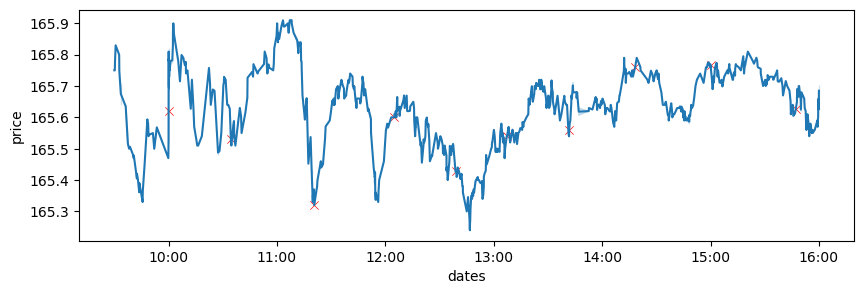

In [17]:
plot_date_sample(df, df_tbar, sample_date)

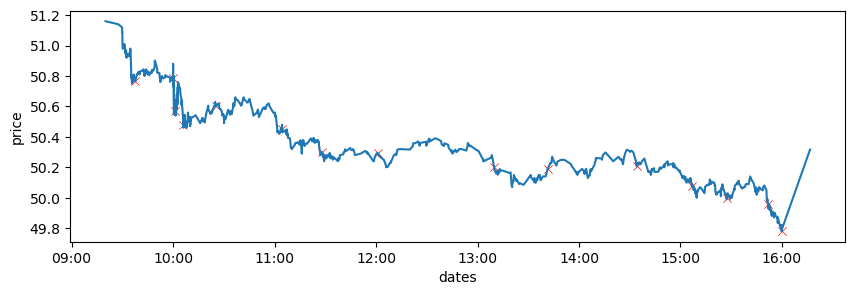

In [18]:
sample_date = '2009-10-01'
plot_date_sample(df, df_tbar, sample_date)

### volume bars

In [19]:
num_volumes = 10_000
df['sum_v'] = df['v'].cumsum()//num_volumes
df_vbar = df.reset_index().groupby('sum_v').last().set_index('dates')

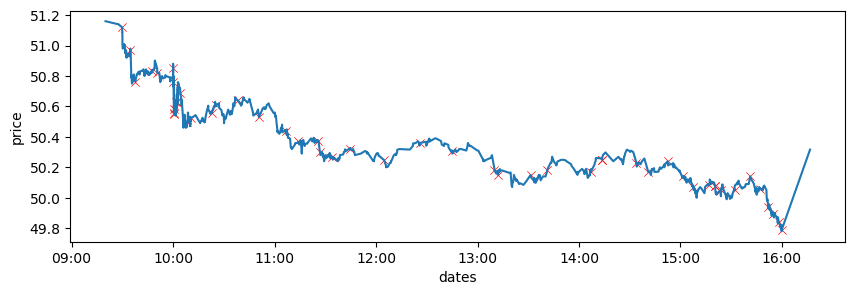

In [20]:
sample_date = '2009-10-01'
plot_date_sample(df, df_vbar, sample_date)

### dollar vars

In [21]:
val_dollars = 1_000_000
df['sum_dv'] = df['dv'].cumsum()//val_dollars
df_dbar = df.reset_index().groupby('sum_dv').last().set_index('dates')

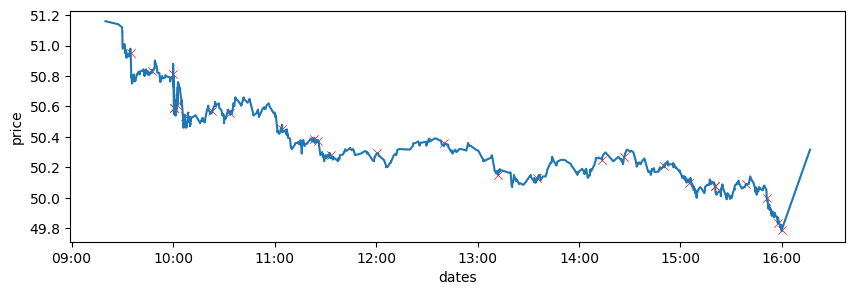

In [22]:
sample_date = '2009-10-01'
plot_date_sample(df, df_dbar, sample_date)

### ohlcv - close

In [23]:
df_daily_close = pd.DataFrame(df.groupby(pd.Grouper(freq='d'))['price'].last().dropna())

### check descriptive stats on created bars

In [24]:
def count_bars(df, price_col='price'):
    return df.groupby(pd.Grouper(freq='W-MON'))['price'].count()
def minmax_scale(s):
    return (s-s.min())/(s.max()-s.min())

In [25]:
df_org = df

In [26]:
print(len(df_org))
print(len(df_tbar))
print(len(df_vbar))
print(len(df_dbar))
print(len(df_daily_close))

2640378
26403
113097
114949
3575


In [27]:
df_org_tmp = df_org[df_org.index <= pd.to_datetime('2018-02-26')]
df_tbar_tmp = df_tbar[df_tbar.index <= pd.to_datetime('2018-02-26')]
df_vbar_tmp = df_vbar[df_vbar.index <= pd.to_datetime('2018-02-26')]
df_dbar_tmp = df_dbar[df_dbar.index <= pd.to_datetime('2018-02-26')]
df_daily_close_tmp = df_daily_close[df_daily_close.index <= pd.to_datetime('2018-02-26')]

In [28]:
def check_cnt(dfs):
    df_org, df_tbar, df_vbar, df_dbar, df_daily_close = dfs

    sr_org_cnt = minmax_scale(count_bars(df_org))
    sr_tbar_cnt = minmax_scale(count_bars(df_tbar))
    sr_vbar_cnt = minmax_scale(count_bars(df_vbar))
    sr_dbar_cnt = minmax_scale(count_bars(df_dbar))
    sr_daily_close_cnt = minmax_scale(count_bars(df_daily_close))

    print(f'org: {sr_org_cnt.std():.5f}')
    print(f'tbar: {sr_tbar_cnt.std():.5f}')
    print(f'vbar: {sr_vbar_cnt.std():.5f}')
    print(f'dbar: {sr_dbar_cnt.std():.5f}')
    print(f'daily_close: {sr_daily_close_cnt.std():.5f}')

dfs = [df_org, df_tbar, df_vbar, df_dbar, df_daily_close]
check_cnt(dfs)
print()
dfs = [df_org_tmp, df_tbar_tmp, df_vbar_tmp, df_dbar_tmp, df_daily_close_tmp]
check_cnt(dfs)


org: 0.09327
tbar: 0.09320
vbar: 0.09436
dbar: 0.11178
daily_close: 0.10162

org: 0.08660
tbar: 0.08600
vbar: 0.12886
dbar: 0.11708
daily_close: 0.10586


In [29]:
def check_autocorr(dfs):
    df_org, df_tbar, df_vbar, df_dbar, df_daily_close = dfs
    autocorr_org = np.log(df_org['price']).diff()[1:].autocorr()
    autocorr_tbar = np.log(df_tbar['price']).diff()[1:].autocorr()
    autocorr_vbar = np.log(df_vbar['price']).diff()[1:].autocorr()
    autocorr_dbar = np.log(df_dbar['price']).diff()[1:].autocorr()
    autocorr_daily_close = np.log(df_daily_close['price']).diff()[1:].autocorr()


    print(f'autocorr_org: {autocorr_org:.5f}')
    print(f'autocorr_tbar: {autocorr_tbar:.5f}')
    print(f'autocorr_vbar: {autocorr_vbar:.5f}')
    print(f'autocorr_dbar: {autocorr_dbar:.5f}')
    print(f'autocorr_daily_close: {autocorr_daily_close:.5f}')

dfs = [df_org, df_tbar, df_vbar, df_dbar, df_daily_close]
check_autocorr(dfs)
print()
dfs = [df_org_tmp, df_tbar_tmp, df_vbar_tmp, df_dbar_tmp, df_daily_close_tmp]
check_autocorr(dfs)

autocorr_org: -0.10656
autocorr_tbar: 0.03164
autocorr_vbar: 0.07797
autocorr_dbar: -0.01835
autocorr_daily_close: -0.11757

autocorr_org: -0.09192
autocorr_tbar: 0.06266
autocorr_vbar: 0.13882
autocorr_dbar: 0.00592
autocorr_daily_close: -0.07319


In [30]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

org_return = returns(df_org['price'])
tbar_return = returns(df_tbar['price'])
vbar_return = returns(df_vbar['price'])
dbar_return = returns(df_dbar['price'])
daily_close_return = returns(df_daily_close['price'])

bar_types = ['org', 'tick','volume','dollar', 'daily']
bar_returns = [
    org_return,
    tbar_return,
    vbar_return,
    dbar_return,
    daily_close_return
]


def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

autocorrs = get_test_stats(bar_types,bar_returns,pd.Series.autocorr)
display(autocorrs.sort_values('autocorr_stat'),
        autocorrs.abs().sort_values('autocorr_stat'))

,sample_size,autocorr_stat
daily,3574.0,-0.117572
org,2640377.0,-0.106559
dollar,114948.0,-0.018349
tick,26402.0,0.031643
volume,113096.0,0.077967


,sample_size,autocorr_stat
dollar,114948.0,0.018349
tick,26402.0,0.031643
volume,113096.0,0.077967
org,2640377.0,0.106559
daily,3574.0,0.117572


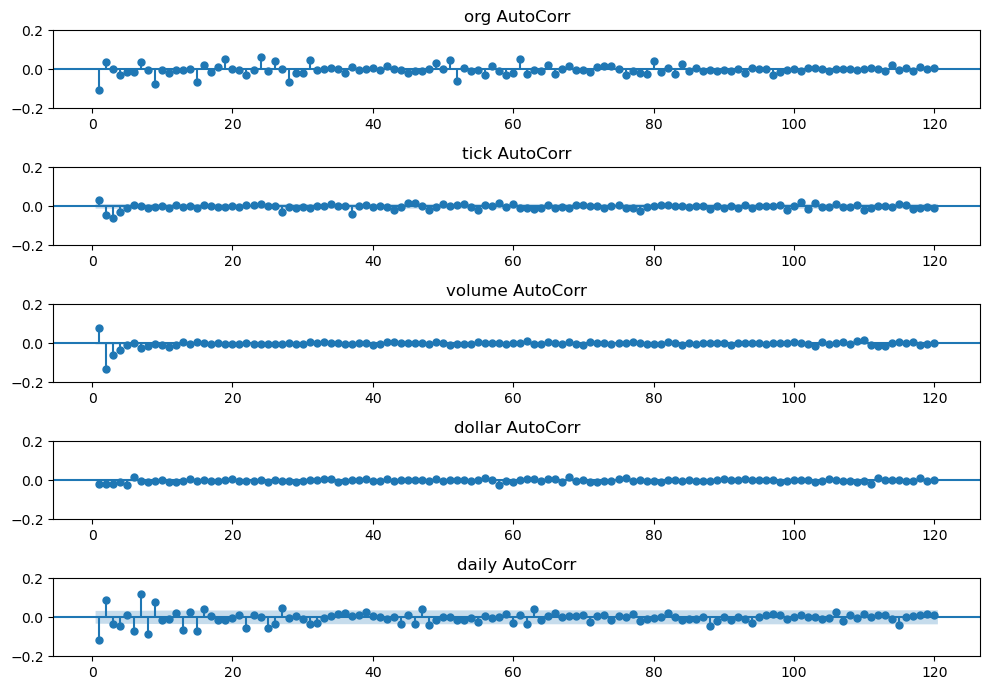

In [31]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
        axes[i].set_ylim([-0.2, 0.2])
        
    plt.tight_layout()   
    
def plot_hist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,6))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ, bins=200)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout() 
plot_autocorr(bar_types,bar_returns)


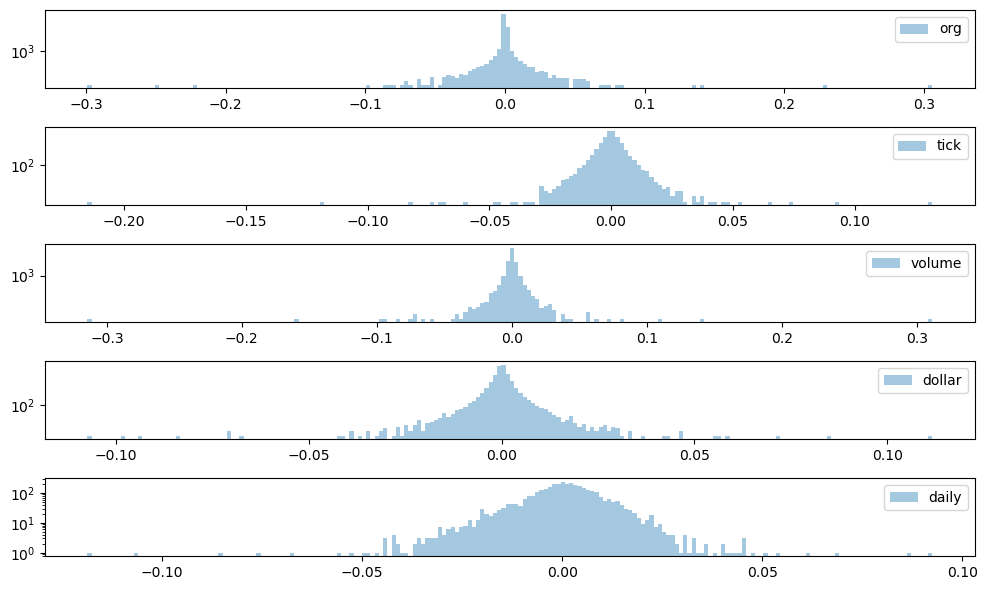

In [32]:
plot_hist(bar_types,bar_returns)

In [33]:
def partition_monthly(s):
    return s.resample('1M').var()

m_org_return = partition_monthly(org_return)
m_tbar_return = partition_monthly(tbar_return)
m_vbar_return = partition_monthly(vbar_return)
m_dbar_return = partition_monthly(dbar_return)
m_daily_close_return = partition_monthly(daily_close_return)


monthly_vars = [
    m_org_return,
    m_tbar_return,
    m_vbar_return,
    m_dbar_return,
    m_daily_close_return
]

get_test_stats(bar_types,monthly_vars,np.var).sort_values('var_stat')


,sample_size,var_stat
org,172.0,3.412060e-12
dollar,172.0,8.829948e-11
volume,172.0,6.879543e-10
tick,172.0,1.270555e-09
daily,172.0,8.362787e-08


In [34]:

def jb(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]


display(get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat'))
display(get_test_stats(bar_types,bar_returns,jb, test=False).sort_values('jb_stat'))

,sample_size,jb_stat
daily,3574.0,2.391934e+04
tick,26402.0,1.059021e+08
dollar,114948.0,6.216440e+08
volume,113096.0,9.252153e+10
org,2640377.0,3.576660e+14


,sample_size,jb_stat
org,2640377.0,0.0
tick,26402.0,0.0
volume,113096.0,0.0
dollar,114948.0,0.0
daily,3574.0,0.0


## References
---

- IVE future tick data from: http://www.kibot.com/free_historical_data.aspx
- https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises